#### Another Use case for clustering is in semi-supervised learning
#### when we have a large dataset with many unlabeled instances and few labeled instances, so we can use clustering to find similar instances and label them with the same label
#### this is called transductive learning

In [81]:
from sklearn.datasets import load_digits

x_digits, y_digits = load_digits(return_X_y=True)
x_train, y_train = x_digits[:1400], y_digits[:1400]
x_test, y_test = x_digits[1400:], y_digits[1400:]

In [82]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(random_state=42, max_iter=10_000)
log_reg.fit(x_train[:n_labeled], y_train[:n_labeled])

log_reg.score(x_test, y_test)

0.7481108312342569

In [83]:
import numpy as np
from sklearn.cluster import KMeans

k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
x_digits_dist = kmeans.fit_transform(x_train)

x_digits_dist

C:\Users\rbblazquez\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[53.8347602 , 41.42507119, 40.38645515, ..., 46.70298587,
        43.32913642, 41.73144964],
       [22.96665235, 50.3636375 , 45.70161035, ..., 48.27458499,
        43.06000537, 50.03512655],
       [29.42934195, 50.1412468 , 43.36356873, ..., 50.49457617,
        47.66591091, 53.60050269],
       ...,
       [49.57764931, 56.45575913, 36.34319282, ..., 46.91590586,
        54.17253975, 56.99134925],
       [49.46706914, 55.89670767, 33.61503416, ..., 46.99966903,
        53.61297942, 54.25569607],
       [38.3721188 , 43.90294928, 48.93405716, ..., 43.3609143 ,
        41.15263129, 37.04745455]])

In [84]:
kmeans.labels_

array([32, 41, 39, ..., 40, 40, 43])

In [85]:
representative_digit_idx = np.argmin(x_digits_dist, axis=0)
representative_digit_idx

array([1120,  708,  582,  925,  597,  384,  798,  970,  768,  815,  885,
       1387,  870,  141, 1084,   88, 1030,  310, 1312,  972,  410, 1168,
        213,  579,  612, 1315,  463, 1075, 1005,  199,  558,  613,  877,
       1352, 1327,  259, 1114,  652,  983,  115, 1328, 1050, 1336,  543,
        938, 1227,  881,  685,  345,  438], dtype=int64)

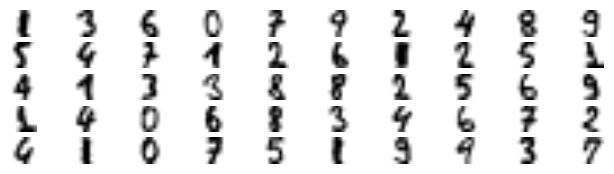

In [86]:
from matplotlib import pyplot as plt

x_representative_digits = x_train[representative_digit_idx]

plt.figure(figsize=(8, 2))

for index, x_representative_digit in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(x_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [87]:
y_representative_digits = np.array([
    1, 3, 6, 0, 7, 9, 2, 4, 8, 9,
    5, 4, 7, 1, 2, 6, 1, 2, 5, 1,
    4, 1, 3, 3, 8, 8, 2, 5, 6, 9,
    1, 4, 0, 6, 8, 3, 4, 6, 7, 2,
    4, 1, 0, 7, 5, 1, 9, 9, 3, 7
])

log_reg = LogisticRegression(random_state=42, max_iter=10_000)
log_reg.fit(x_representative_digits, y_representative_digits)

log_reg.score(x_test, y_test)

### Now we can propagate the labels to the rest of the training instances, so we will create an empty array and for each cluster we will assign the label of the most representative digit (the kmeans.labels_ array contains the nearest cluster number for each instance),

In [88]:
y_train_propagated = np.empty(len(x_train), dtype=np.int64)
print(kmeans.labels_.shape)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

y_train_propagated # now we have the labels for the rest of the training instances

(1400,)


array([0, 1, 2, ..., 4, 4, 7], dtype=int64)

In [89]:
log_reg = LogisticRegression(random_state=42, max_iter=10_000)
log_reg.fit(x_train, y_train_propagated)

log_reg.score(x_test, y_test) # we got a better score than before because we propagated the labels to the rest of the training instances

0.8967254408060453

### now we are going to try to find outliers in the dataset

In [90]:
percentile_closes = 99

x_cluster_dist = x_digits_dist[np.arange(len(x_train)), kmeans.labels_] # we get for each instance the distance to its nearest cluster

x_cluster_dist.shape

(1400,)

In [91]:
for cluster_number in range(k):
    in_cluster = (kmeans.labels_ == cluster_number)
    cluster_dist = x_cluster_dist[in_cluster]

    cutoff_distance = np.percentile(cluster_dist, percentile_closes)
    above_cutoff = (x_cluster_dist > cutoff_distance)

    x_cluster_dist[in_cluster & above_cutoff] = -1 # we set the distance to -1 for the outliers

x_cluster_dist[x_cluster_dist != -1].shape

(1350,)

In [92]:
partially_propagated = (x_cluster_dist != -1)
x_train_partially_propagated = x_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [93]:
log_reg = LogisticRegression(random_state=42, max_iter=10_000)
log_reg.fit(x_train_partially_propagated, y_train_partially_propagated)

log_reg.score(x_test, y_test)

0.9093198992443325

In [94]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

0.9755555555555555